In [17]:
import pandas as pd
import re
from spaczz.matcher import FuzzyMatcher
import spacy
import string

import os
from pathlib import Path
import duckdb as ddb
from pandas_plots import tbl, pls, hlp

hlp.show_package_version()
os.environ['THEME']='light'

dir_db=Path("C://temp") if hlp.get_os(hlp.OperatingSystem.WINDOWS) else Path(os.path.expanduser("~/tmp"))

# ! use either clin or fake data
# file_db_clin = dir_db/'2025-06-24_data_clin.duckdb'
file_db_clin = Path('.local/fake_clin_data.duckdb')

if not file_db_clin.exists():
    raise FileNotFoundError(f"File not found: {file_db_clin}")

🐍 3.11.7 | 📦 pandas: 2.3.1 | 📦 numpy: 1.26.4 | 📦 duckdb: 1.3.2 | 📦 pandas-plots: 0.12.30 | ❌ connection-helper: Not found


In [18]:
con = ddb.connect(file_db_clin, read_only=True)
_=con.execute("PRAGMA disable_progress_bar;")
# _=con.execute(f"ATTACH DATABASE '{file_db_clin}' as clin; set schema 'clin';")

In [19]:
sub_data = con.sql("select distinct Bezeichnung from Substanz").to_df()
display(sub_data)
# sub_data.head()

,Bezeichnung
0,Idarubicin
1,Pegfilgrastim
2,Fluorouracil
3,Leuprorelin
4,Apalutamid
5,Zoledronsäure
6,Bleomycin
7,Mercaptopurin
8,None
9,Lenalidomid


In [20]:
URL_V2 = "https://gitlab.opencode.de/robert-koch-institut/zentrum-fuer-krebsregisterdaten/cancerdata-references/-/raw/main/data/v2/Klassifikationen/substanz.csv?ref_type=heads"
reference_list = pd.read_csv(URL_V2, sep=";")
reference_list.head()

,therapieart,substanz,code
0,HO,Abarelix,L02BX01
1,IM,Abatacept,L04AA24
2,ZS,Abemaciclib,L01EF03
3,IM,Abetimus,L04AA22
4,HO,Abirateron,L02BX03


In [21]:
col_with_substances = sub_data["Bezeichnung"]
col_with_ref_substances = reference_list["substanz"]

In [22]:
import re
import spacy
from spaczz.matcher import FuzzyMatcher

# ----------- Preparation Functions -----------

def prepare_free_text(input_col: pd.Series) -> pd.DataFrame:
    """Prepares data by renaming, stripping, and cleaning null or empty entries."""
    input_data = pd.DataFrame({
        "ID": range(1, len(input_col) + 1),
        "Original": input_col.fillna("NA").replace("", "NA")
    })
    input_data["Original"] = input_data["Original"].astype(str).str.strip()
    return input_data


def remove_short_words(text: str) -> str:
    return " ".join([word for word in text.split() if len(word) >= 3])


def find_5FU(text: str) -> str:
    pattern = (
        r"5 fu|5fu|5-fu|5_fu|Fluoruracil|flourouracil|5-fluoruuracil|"
        r"5-fluoro-uracil|5-fluoruuracil|5-fluoruracil|floururacil|"
        r"5-fluorounacil|flourouraci|5-fluourouracil"
    )
    return re.sub(pattern, "fluorouracil", text, flags=re.IGNORECASE)


def calciumfolinat_to_folin(text: str) -> str:
    return re.sub(r"\b(Calciumfolinat)\b", "folinsäure", text, flags=re.IGNORECASE)


def find_gemcitabin(text: str) -> str:
    return re.sub(r"Gemcibatin(?:e)?(?: Mono)?", "gemcitabin", text, flags=re.IGNORECASE)


def find_Paclitaxel_nab(text: str) -> str:
    return re.sub(r"\bnab[\s\-]?Paclitaxel\b", "Paclitaxel nab", text, flags=re.IGNORECASE)


# ----------- Preprocessing Pipeline -----------

def preprocess_data(col_with_free_text: pd.Series) -> pd.DataFrame:
    df = prepare_free_text(col_with_free_text)
    processed = (
        df["Original"]
        .apply(find_5FU)
        .apply(find_gemcitabin)
        .apply(find_Paclitaxel_nab)
        .apply(calciumfolinat_to_folin)
        .apply(remove_short_words)
        .str.strip()
    )
    df["Preprocessed_text"] = processed
    return df


# ----------- Matching Function -----------

def get_matches(preprocessed_data: pd.DataFrame, ref_substance: pd.Series,
                threshold=0.8, max_per_match_id=2, only_first_match=False) -> pd.DataFrame:
   
    nlp = spacy.blank("en")
    matcher = FuzzyMatcher(nlp.vocab)

    # Add each reference substance to matcher
    for sub in ref_substance.dropna().astype(str):
        matcher.add(sub, [nlp(sub)])

    results = []

    for _, row in preprocessed_data.iterrows():
        text = row["Preprocessed_text"]
        original = row["Original"]
        doc = nlp(text)
        matches = matcher(doc)

        # Filter and sort matches
        matches_filtered = [m for m in matches if m[3] >= threshold * 100]
        matches_sorted = sorted(matches_filtered, key=lambda x: x[3], reverse=True)

        result_row = {"Original": original}
        result_row["Preprocessed"] = text
        match_id_counts = {}
        match_idx = 1

        for match_id, start, end, ratio, _ in matches_sorted:
            count = match_id_counts.get(match_id, 0)
            if count >= max_per_match_id:
                continue

            result_row[f"Hit{match_idx}"] = match_id
            result_row[f"Mapped_to{match_idx}"] = doc[start:end].text
            result_row[f"Similarity{match_idx}"] = ratio

            match_id_counts[match_id] = count + 1
            match_idx += 1

        results.append(result_row)
    
    out = pd.DataFrame(results)

    if only_first_match:
        cols_to_keep = ["Original", "Preprocessed", "Hit1", "Mapped_to1", "Similarity1"]
        available_columns = [col for col in cols_to_keep if col in out.columns]
        dta_col_selected = out[available_columns]
        dta_col_selected.columns = [re.sub(r"\d+$", "", col) for col in dta_col_selected.columns]        
        return(dta_col_selected)
        
    return out

preprocessed_out = preprocess_data(col_with_substances)
final_output = get_matches(preprocessed_out, col_with_ref_substances, only_first_match=True)

🔵 *** df: final_output ***  
🟣 shape: (11, 5) columns: ['Original' 'Preprocessed' 'Hit' 'Mapped_to' 'Similarity']  
🟣 duplicates: 0  
🟣 uniques: [{Original: 11 Preprocessed: 11 Hit: 10 Mapped_to: 10 Similarity: 1}]  
🟣 missings: [{Original: 0 Preprocessed: 0 Hit: 1 Mapped_to: 1 Similarity: 1}]  
--- column uniques (all)  
🟠 index [0, 1, 2, 3, 4,]  
🟠 Original(11|object)   ['Apalutamid', 'Bleomycin', 'Fluorouracil', 'Idarubicin', 'Lenalidomid',]  
🟠 Preprocessed(11|object)   ['', 'Apalutamid', 'Bleomycin', 'Fluorouracil', 'Idarubicin',]  
🟠 Hit(11|object)   ['<NA>', 'Apalutamid', 'Bleomycin', 'Fluorouracil', 'Idarubicin',]  
🟠 Mapped_to(11|object)   ['<NA>', 'Apalutamid', 'Bleomycin', 'Fluorouracil', 'Idarubicin',]  
🟠 Similarity(1|float64)   [100.0,]  
--- column stats (numeric)  
Similarity -> min: 100.0 | lower: 100.0 | q25: 100.0 | median: 100.0 | mean: 100.0 | q75: 100.0 | upper: 100.0 | max: 100.0 | std: 0.0 | cv: 0.0 | sum: 1_000.0 | skew: nan | kurto: nan  


,Original,Preprocessed,Hit,Mapped_to,Similarity
0,Idarubicin,Idarubicin,Idarubicin,Idarubicin,100.0
1,Pegfilgrastim,Pegfilgrastim,Pegfilgrastim,Pegfilgrastim,100.0
2,Fluorouracil,Fluorouracil,Fluorouracil,Fluorouracil,100.0


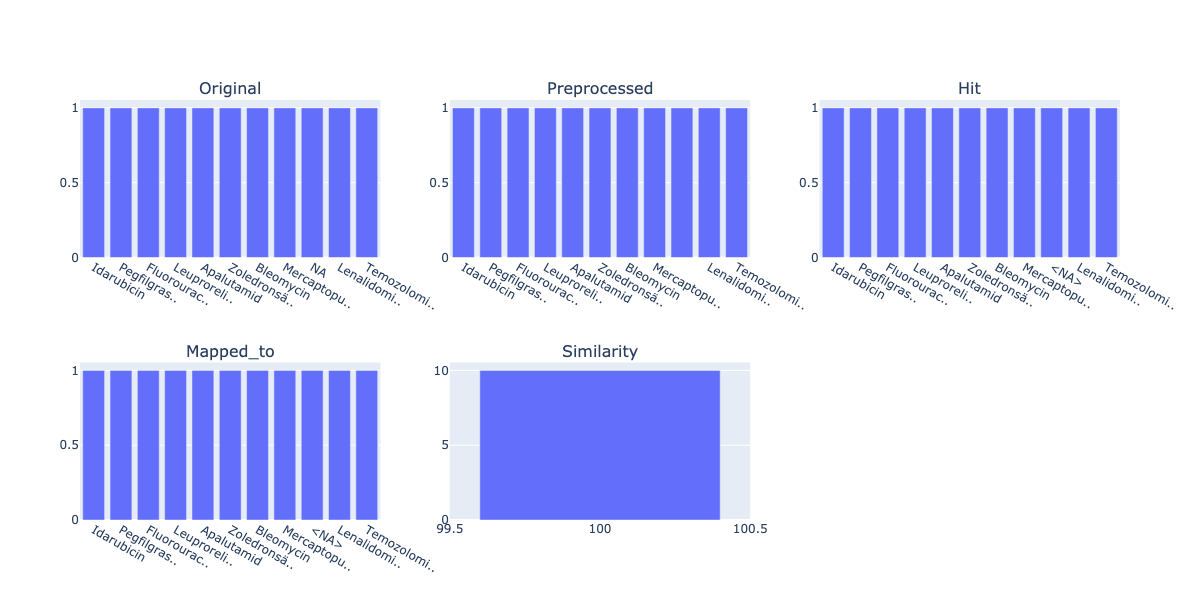

In [23]:
tbl.describe_df(
    final_output,
    "final_output",
    top_n_uniques=5,
    top_n_chars_in_index=10,
)

In [8]:
final_output.to_csv(".local/out1.csv", index=False)

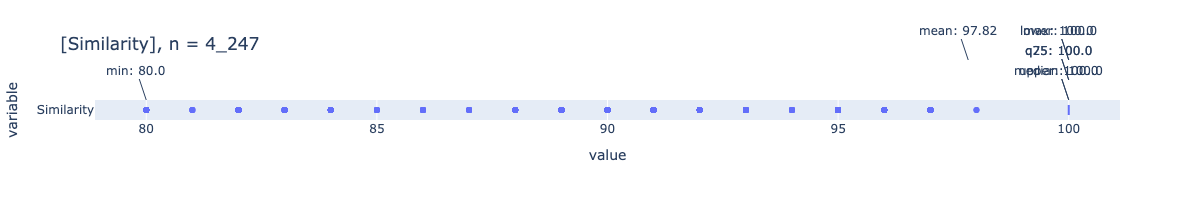

Similarity -> min: 80.0 | lower: 100.0 | q25: 100.0 | median: 100.0 | mean: 97.821 | q75: 100.0 | upper: 100.0 | max: 100.0 | std: 4.603 | cv: 0.047 | sum: 245_041.0 | skew: -2.266 | kurto: 4.476  


In [11]:
_=pls.plot_box(final_output["Similarity"])

## analysis

In [12]:
col_with_substances_ZfKD_fake_data = sub_data
col_with_ref_substances_ZfKD = reference_list["substanz"]

In [13]:
# define function to extract valid substances
def create_substance_service_var(
    col_with_substances: pd.Series,
    col_with_ref_substances: pd.Series,
    threshold: float = 0.85,
    max_per_match_id: int = 2,
    only_first_match: bool = False,
) -> pd.DataFrame:
    """
    This is the pipeline for creating the service variable
    for substances using ZfKD data.
    The functions are described in detail in utils.py.
    In short, the functions takes a pandasDataFrame column
    as an input and preprocesses its entries first.
    This results in a pandasDataFrame with the original
    input in one column and the preprocessed text in another one.
    The fuzzy matching relies on FuzzyMatcher from spaczz.
    It uses the preprocessed input and a reference list that
    the uses needs to provide. The reference list must be 
    a pandasDataFrame column (pd.Series) with substance names.
    The output is a pandasDataFrame with the original input,
    the preprocessed text and all possible matches with similary score.
    Use parameters to control output and sensitivity of the matcher. 
    """
    preprocessed_out = preprocess_data(col_with_substances)

    final_output = get_matches(
        preprocessed_out,
        col_with_ref_substances,
        threshold=threshold,
        max_per_match_id=max_per_match_id,
        only_first_match=only_first_match,
    )

    return final_output

In [14]:
# containers
threshold_value = []
similarity_mean = []
match_count = []

threshold_range = range(60, 100)

for threshold in threshold_range:
    results_atomic = create_substance_service_var(
        col_with_substances=col_with_substances_ZfKD_fake_data,
        col_with_ref_substances=col_with_ref_substances_ZfKD,
        only_first_match=True,
        max_per_match_id=1,
        threshold=threshold/100  
    )

    valid_hits = results_atomic["Hit"].dropna()
    valid_hits = valid_hits[valid_hits != ""]
    count = len(valid_hits)

    mean_sim = pd.to_numeric(results_atomic["Similarity"], errors='coerce').mean()

    threshold_value.append(threshold)
    match_count.append(count)
    similarity_mean.append(mean_sim)


results_df = pd.DataFrame({
    "threshold": threshold_value,
    "match_count": match_count,
    "similarity_mean": similarity_mean
})

print(results_df)

ValueError: 2

In [15]:
results_df['match_count_relative'] = results_df['match_count'] / len(col_with_substances_ZfKD_fake_data)

NameError: name 'results_df' is not defined

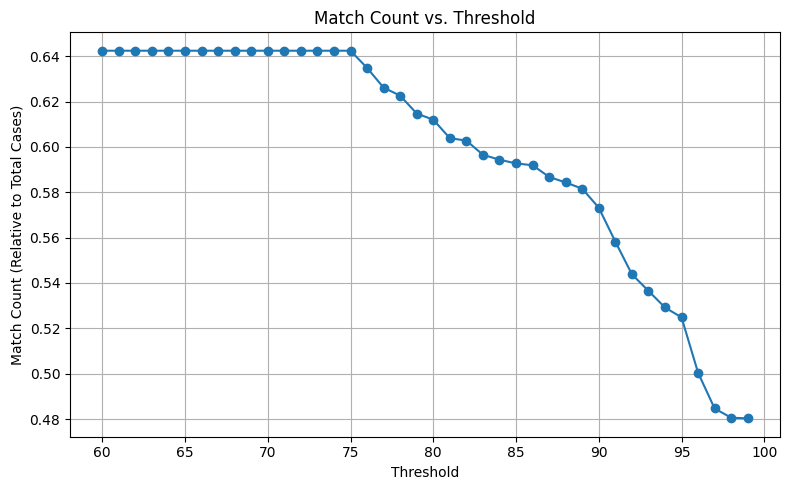

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(results_df['threshold'], results_df['match_count_relative'], marker='o')
plt.xlabel('Threshold')
plt.ylabel('Match Count (Relative to Total Cases)')
plt.title('Match Count vs. Threshold')
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/plot_match_count_vs_threshold.png', dpi=300)
plt.show()

In [ ]:
col_with_made_up_data = pd.Series(["Interferon alpha 2a", "Paclitaxel (nab)", "Filgrastim", "Leuprorelin; Tamoxifen"])

results_atomic = create_substance_service_var(
    col_with_substances=col_with_made_up_data,
    col_with_ref_substances=col_with_ref_substances_ZfKD,
    only_first_match=True
)

results_multiple_hits = create_substance_service_var(
    col_with_substances=col_with_made_up_data,
    col_with_ref_substances=col_with_ref_substances_ZfKD,
    only_first_match=False,
    threshold=0.85,
    max_per_match_id=2
)

In [ ]:
results_atomic.head()

,Original,Preprocessed,Hit,Mapped_to,Similarity
0,Interferon alpha 2a,Interferon alpha,Interferon alpha,Interferon alpha-2a,91
1,Paclitaxel (nab),Paclitaxel (nab),Paclitaxel,Paclitaxel,100
2,Filgrastim,Filgrastim,Filgrastim,Filgrastim,100
3,Leuprorelin; Tamoxifen,Leuprorelin; Tamoxifen,Leuprorelin,Leuprorelin,100


In [ ]:
results_multiple_hits.head()

,Original,Preprocessed,Hit1,Mapped_to1,Similarity1,Hit2,Mapped_to2,Similarity2
0,Interferon alpha 2a,Interferon alpha,Interferon alpha,Interferon alpha-2a,91,Interferon alpha,Interferon alpha-2b,91
1,Paclitaxel (nab),Paclitaxel (nab),Paclitaxel,Paclitaxel,100,Paclitaxel (nab,Paclitaxel nab,97
2,Filgrastim,Filgrastim,Filgrastim,Filgrastim,100,Filgrastim,Pegfilgrastim,87
3,Leuprorelin; Tamoxifen,Leuprorelin; Tamoxifen,Leuprorelin,Leuprorelin,100,Tamoxifen,Tamoxifen,100


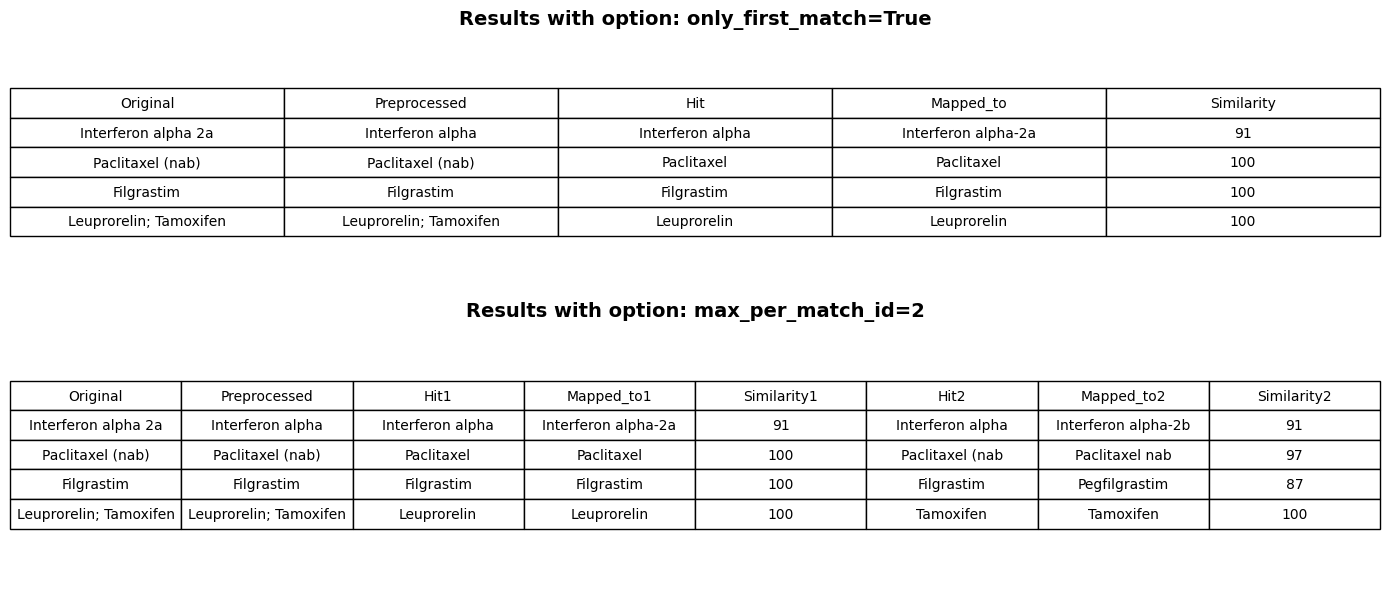

In [ ]:
table_data1 = results_atomic.head()
table_data2 = results_multiple_hits.head()

# Set up vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))  # Adjust height as needed

# Plot first table
ax1.axis('off')
ax1.set_title('Results with option: only_first_match=True', fontsize=14, fontweight='bold', pad=10)
table1 = ax1.table(cellText=table_data1.values,
                   colLabels=table_data1.columns,
                   cellLoc='center',
                   loc='center')
table1.auto_set_font_size(False)
table1.set_fontsize(10)
table1.scale(1, 1.5)

# Plot second table
ax2.axis('off')
ax2.set_title('Results with option: max_per_match_id=2', fontsize=14, fontweight='bold', pad=10)
table2 = ax2.table(cellText=table_data2.values,
                   colLabels=table_data2.columns,
                   cellLoc='center',
                   loc='center')
table2.auto_set_font_size(False)
table2.set_fontsize(10)
table2.scale(1, 1.5)

# Save the figure
plt.tight_layout()
plt.savefig('../images/atomic_vs_multiple.png', dpi=300, bbox_inches='tight')
plt.show()